In [1]:
# -*- coding: utf-8 -*-
#no batch norm
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, average_precision_score
from skimage.transform import resize
import scipy.io

import matplotlib.pyplot as plt
import itertools
import numpy as np
import time
import shutil
import os

Using TensorFlow backend.


In [2]:
# Fixing random state for reproducibility
seed = 19960925
np.random.seed(seed)
img_rows = 32
img_cols = 32
channels = 3
num_classes = 2


In [3]:
def load_TMI_data():
    # Load the dataset
    dataset = scipy.io.loadmat('TMI2015/training/training.mat')

    # Split into train and test. Values are in range [0..1] as float64
    X_train = np.transpose(dataset['train_x'], (3, 0, 1, 2))
    y_train = list(dataset['train_y'][0])
    
    X_test = np.transpose(dataset['test_x'], (3, 0, 1, 2))
    y_test = list(dataset['test_y'][0])
    
    # Change shape and range. 
    y_train = np.asarray(y_train).reshape(-1, 1)
    y_test = np.asarray(y_test).reshape(-1, 1)

#   1-> 0 : Non-nucleus. 2 -> 1: Nucleus
    y_test -= 1
    y_train -= 1

    # Resize to 32x32
    X_train_resized = np.empty([X_train.shape[0], 32, 32, X_train.shape[3]])
    for i in range(X_train.shape[0]):
        X_train_resized[i] = resize(X_train[i], (32, 32, 3), mode='reflect')

    X_test_resized = np.empty([X_test.shape[0], 32, 32, X_test.shape[3]])
    for i in range(X_test.shape[0]):
        X_test_resized[i] = resize(X_test[i], (32, 32, 3), mode='reflect')

    #Plotting a sample data:
    r, c = 5, 5
    fig, axs = plt.subplots(r, c)
#
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(X_train_resized[np.random.randint(0,6000)])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("./TMI_generators_output/tmi_training_random_sample.png")
    plt.suptitle('Non-nuclei Training Sample - label = 1')
    plt.show()
#
    r, c = 5, 5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(X_train_resized[np.random.randint(6000,8000)])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("./TMI_generators_output/tmi_training_random_sample.png")
    plt.suptitle('Nuclei Training Sample - label = 2')
    plt.show()
    
    # Normalize images from [0..1] to [-1..1]
    X_train_resized = 2 * X_train_resized - 1
    X_test_resized = 2 * X_test_resized - 1

    return X_train_resized, y_train, X_test_resized, y_test

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def build_generator():
    model = Sequential()

    model.add(Dense(128 * 8 * 8, activation="relu", input_dim=100))

    model.add(Reshape((8, 8, 128)))
    model.add(BatchNormalization(momentum=0.6))

    # fractionally-strided convolution, do not confuse with deconvolution operation
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))

    model.add(Activation("relu"))
    #model.add(BatchNormalization(momentum=0.6))

    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    #model.add(BatchNormalization(momentum=0.6))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.summary()

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)

def build_discriminator():

    img_shape = (img_rows, img_cols, channels)

    # A Sequential model is a linear stack of layers.
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))

    model.add(LeakyReLU(alpha=0.2))


    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    #A zero-padding layer. Adds rows and columns of zeros to the image
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(LeakyReLU(alpha=0.2))

    model.add(BatchNormalization(momentum=0.6))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    #model.add(Dropout(0.25))
    model.add(BatchNormalization(momentum=0.6))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.summary()


    # instantiate a Keras tensor
    img = Input(shape=img_shape)
    features = model(img)

    # valid indicates if the image is real or fake
    valid = Dense(1, activation="sigmoid")(features)
    # iff the image is real, label indicates which type of image it is
    label = Dense(num_classes+1, activation="softmax")(features)

    # Given an img (x)  and a label(y), instantiate a Model.
    # Once instantiated, this model will include all layers required in the computation of y given x.
    return Model(img, [valid, label])

In [6]:
def train( X_train, y_train, X_test, y_test, epochs, batch_size, save_interval):

    # delete directory if exist and create it
    shutil.rmtree('TMI_generators_output', ignore_errors=True)
    os.makedirs("TMI_generators_output")

    #half_batch = int(batch_size / 2)
    half_batch = batch_size
    # Class weights:
    # To balance the difference in occurences of class labels.
    # 50% of labels that D trains on are 'fake'.
    # Weight = 1 / frequency
    cw1 = {0: 1, 1: 1}
    cw2 = {i: num_classes / half_batch for i in range(num_classes)}
    cw2[num_classes] = 1 / half_batch

    for epoch in range(epochs):
        # ---------------------
        #  Training the Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Draw random samples from a Gaussian distribution.
        noise = np.random.normal(0, 1, (half_batch, 100))
        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)

        valid = np.ones((half_batch, 1))
        fake = np.zeros((half_batch, 1))

        # Convert labels to categorical one-hot encoding
        labels = to_categorical(y_train[idx], num_classes=num_classes+1)
        fake_labels = to_categorical(np.full((half_batch, 1), num_classes), num_classes=num_classes+1)

        # Train the discriminator (real classified as ones and fakes as zeros)
        # train_on_batch: Single gradient update over one batch of samples
        d_loss_real = discriminator.train_on_batch(imgs, [valid, labels], class_weight=[cw1, cw2])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, fake_labels], class_weight=[cw1, cw2])
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Training the Generator
        # ---------------------
        validity = np.ones((batch_size, 1))

        for i in range(10):
            noise = np.random.normal(0, 1, (batch_size, 100))
            # Train the generator (wants discriminator to mistake images as real)
            g_loss = combined.train_on_batch(noise, validity, class_weight=[cw1, cw2])

        training_history["D_loss"].append(d_loss[0]);
        training_history["D_acc"].append(100*d_loss[3]);
        training_history["G_loss"].append(g_loss);
        training_history["G_acc"].append(100*d_loss[4]);

        print ("%d: Training D [loss: %.4f, acc: %.2f%% ] - G [loss: %.4f, acc: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[3], g_loss, 100*d_loss[4]))
        evaluate_discriminator(X_test, y_test)

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [7]:
def evaluate_discriminator( X_test, y_test):
    valid = np.ones((y_test.shape[0], 1))

    # Convert labels to categorical one-hot encoding
    labels = to_categorical(y_test, num_classes=num_classes+1)

    #  Evaluating the trained Discriminator
    scores = discriminator.evaluate(X_test, [valid, labels], verbose=0)

    print("Evaluating D [loss:  %.4f, bi-loss: %.4f, cat-loss: %.4f, bi-acc: %.2f%%, cat-acc: %.2f%%]\n" %
          (scores[0], scores[1], scores[2], scores[3]*100, scores[4]*100))
#        print("\nEvaluating D [loss:  %.4f, acc: %.2f%%]" % (scores[0], scores[3]*100))

    return (scores[0], scores[3]*100)

In [8]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images from [-1..1] to [0..1] just to display purposes.
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("./TMI_generators_output/tmi_%d.png" % epoch)
    plt.close()

In [9]:
def save_model():

    def save(model, model_name):
        model_path = "./TMI_saved_models/%s.json" % model_name
        weights_path = "./TMI_saved_models/%s_weights.hdf5" % model_name
        options = {"file_arch": model_path,
                    "file_weight": weights_path}
        json_string = model.to_json()
        open(options['file_arch'], 'w').write(json_string)
        model.save_weights(options['file_weight'])

    shutil.rmtree('TMI_saved_models', ignore_errors=True)
    os.makedirs("TMI_saved_models")

    save(generator, "TMI_gan_generator")
    save(discriminator, "TMI_gan_discriminator")
    save(combined, "TMI_gan_adversarial")

In [10]:
def plot_training_history():
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    plt.title('Training History')
    # summarize history for G and D accuracy
    axs[0].plot(range(1,len(training_history['D_acc'])+1),training_history['D_acc'])
    axs[0].plot(range(1,len(training_history['G_acc'])+1),training_history['G_acc'])
    axs[0].set_title('D and G Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(training_history['D_acc'])+1),len(training_history['D_acc'])/10)
    axs[0].set_yticks([n for n in range(0, 101,10)])
    axs[0].legend(['Discriminator', 'Generator'], loc='best')

    # summarize history for G and D loss
    axs[1].plot(range(1,len(training_history['D_loss'])+1),training_history['D_loss'])
    axs[1].plot(range(1,len(training_history['G_loss'])+1),training_history['G_loss'])
    axs[1].set_title('D and G Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(training_history['G_loss'])+1),len(training_history['G_loss'])/10)
    axs[1].legend(['Discriminator', 'Generator'], loc='best')
    plt.show()

In [11]:
def predict( X_test, y_test):

    # Generating a predictions from the discriminator over the testing dataset
    y_pred = discriminator.predict(X_test)

    # Formating predictions to remove the one_hot_encoding format
    y_pred = np.argmax(y_pred[1][:,:-1], axis=1)

    print ('\nOverall accuracy: %f%% \n' % (accuracy_score(y_test, y_pred) * 100))
    print ('\nAveP: %f%% \n' % (average_precision_score(y_test, y_pred) * 100))

    # Calculating and ploting a Classification Report
    class_names = ['Non-nunclei', 'Nuclei']
    print("Classification report:\n %s\n"
          % (classification_report(y_test, y_pred, target_names=class_names)))

    # Calculating and ploting Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
#        print("Confusion matrix:\n%s" % cm)

    plt.figure()
    plot_confusion_matrix(cm, class_names, title='Confusion matrix, without normalization')

    plt.figure()
    plot_confusion_matrix(cm, class_names, normalize=True, title='Normalized confusion matrix')

In [12]:
training_history = {
        'D_loss': [],
        'D_acc': [],
        'G_loss': [],
        'G_acc': [],
        }
        # TMI input shape (after resized)is 32x32x3

optimizer = Adam(0.0002, 0.5)
#build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(100,))
img = generator(z)

        # Build discriminator's model
discriminator = build_discriminator()

discriminator.compile(
        loss=['binary_crossentropy', 'categorical_crossentropy'],
        loss_weights=[0.5, 0.5],
        optimizer=optimizer,
        metrics=['accuracy'])
# For the combined model we will only train the generator
discriminator.trainable = False

# For the combined model we will only train the generator
discriminator.trainable = False
# The discriminator takes generated images as input and determines validity
valid, _ =discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity
combined = Model(z, valid)
combined.compile(
        loss=['binary_crossentropy'], 
        optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
up_s

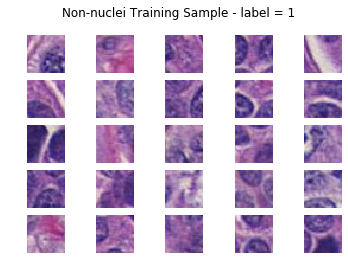

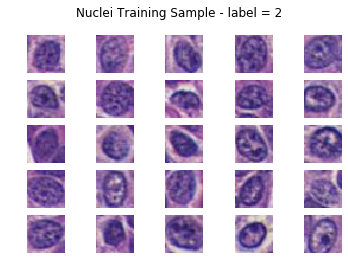

In [13]:
if __name__ == '__main__':

    X_train, y_train, X_test, y_test = load_TMI_data()

In [14]:
    start = time.time()
    
    epochs=200
    # Fit/Train the model
    train(X_train, y_train, X_test, y_test, epochs, batch_size=32, save_interval=5)

    end = time.time()
    print ("\nTraining time: %0.1f minutes \n" % ((end-start) / 60))

    #saved the trained model
    save_model()


#    evaluate the trained D model w.r.t unseen data (i.e. testing set)

    evaluate_discriminator(X_test, y_test)

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Instructions for updating:
Use tf.cast instead.
0: Training D [loss: 0.6932, acc: 42.19% ] - G [loss: 0.1489, acc: 31.25%]
Evaluating D [loss:  0.8871, bi-loss: 0.6774, cat-loss: 1.0968, bi-acc: 100.00%, cat-acc: 40.60%]

1: Training D [loss: 0.6476, acc: 46.88% ] - G [loss: 0.1590, acc: 34.38%]
Evaluating D [loss:  0.8952, bi-loss: 0.6951, cat-loss: 1.0954, bi-acc: 37.90%, cat-acc: 45.30%]

2: Training D [loss: 0.9569, acc: 21.88% ] - G [loss: 0.1053, acc: 31.25%]
Evaluating D [loss:  0.8980, bi-loss: 0.7014, cat-loss: 1.0946, bi-acc: 11.90%, cat-acc: 44.90%]

3: Training D [loss: 0.9048, acc: 10.94% ] - G [loss: 0.1698, acc: 60.94%]
Evaluating D [loss:  0.8950, bi-loss: 0.6972, cat-loss: 1.0928, bi-acc: 24.60%, cat-acc: 47.80%]

4: Training D [loss: 0.6560, acc: 35.94% ] - G [loss: 0.1643, acc: 51.56%]
Evaluating D [loss:  0.8956, bi-loss: 0.6994, cat-loss: 1.0918, bi-acc: 13.50%, cat-acc: 49.10%]

5: Training D [loss: 0.7389, acc: 45.31% ] - G [loss: 0.4147, acc: 45.31%]
Evaluating 

46: Training D [loss: 0.6849, acc: 20.31% ] - G [loss: 0.5442, acc: 32.81%]
Evaluating D [loss:  0.8970, bi-loss: 0.7196, cat-loss: 1.0743, bi-acc: 0.10%, cat-acc: 71.00%]

47: Training D [loss: 0.6567, acc: 25.00% ] - G [loss: 0.8789, acc: 40.62%]
Evaluating D [loss:  0.8952, bi-loss: 0.7179, cat-loss: 1.0726, bi-acc: 0.20%, cat-acc: 72.90%]

48: Training D [loss: 0.5415, acc: 42.19% ] - G [loss: 0.4684, acc: 39.06%]
Evaluating D [loss:  0.8955, bi-loss: 0.7178, cat-loss: 1.0732, bi-acc: 0.40%, cat-acc: 71.40%]

49: Training D [loss: 0.7434, acc: 23.44% ] - G [loss: 0.3553, acc: 39.06%]
Evaluating D [loss:  0.8956, bi-loss: 0.7185, cat-loss: 1.0728, bi-acc: 0.10%, cat-acc: 73.60%]

50: Training D [loss: 0.7196, acc: 15.62% ] - G [loss: 0.6817, acc: 35.94%]
Evaluating D [loss:  0.8954, bi-loss: 0.7179, cat-loss: 1.0730, bi-acc: 0.00%, cat-acc: 78.80%]

51: Training D [loss: 0.4839, acc: 40.62% ] - G [loss: 0.6569, acc: 39.06%]
Evaluating D [loss:  0.8937, bi-loss: 0.7131, cat-loss: 1.0

Evaluating D [loss:  0.8930, bi-loss: 0.7121, cat-loss: 1.0740, bi-acc: 1.30%, cat-acc: 87.10%]

94: Training D [loss: 0.5437, acc: 25.00% ] - G [loss: 0.5071, acc: 57.81%]
Evaluating D [loss:  0.8927, bi-loss: 0.7116, cat-loss: 1.0738, bi-acc: 1.50%, cat-acc: 84.40%]

95: Training D [loss: 0.5639, acc: 23.44% ] - G [loss: 0.5251, acc: 45.31%]
Evaluating D [loss:  0.8923, bi-loss: 0.7113, cat-loss: 1.0733, bi-acc: 1.20%, cat-acc: 86.60%]

96: Training D [loss: 0.5652, acc: 25.00% ] - G [loss: 0.5426, acc: 42.19%]
Evaluating D [loss:  0.8927, bi-loss: 0.7122, cat-loss: 1.0733, bi-acc: 0.30%, cat-acc: 89.90%]

97: Training D [loss: 0.5890, acc: 23.44% ] - G [loss: 0.5719, acc: 46.88%]
Evaluating D [loss:  0.8924, bi-loss: 0.7110, cat-loss: 1.0737, bi-acc: 0.20%, cat-acc: 89.80%]

98: Training D [loss: 0.6209, acc: 15.62% ] - G [loss: 0.5230, acc: 48.44%]
Evaluating D [loss:  0.8922, bi-loss: 0.7099, cat-loss: 1.0745, bi-acc: 0.40%, cat-acc: 89.20%]

99: Training D [loss: 0.5111, acc: 35.

141: Training D [loss: 0.4401, acc: 37.50% ] - G [loss: 0.6573, acc: 57.81%]
Evaluating D [loss:  0.8951, bi-loss: 0.7102, cat-loss: 1.0800, bi-acc: 0.00%, cat-acc: 77.90%]

142: Training D [loss: 0.5470, acc: 18.75% ] - G [loss: 0.6871, acc: 50.00%]
Evaluating D [loss:  0.8940, bi-loss: 0.7090, cat-loss: 1.0790, bi-acc: 0.20%, cat-acc: 80.30%]

143: Training D [loss: 0.4432, acc: 29.69% ] - G [loss: 0.6120, acc: 53.12%]
Evaluating D [loss:  0.8934, bi-loss: 0.7084, cat-loss: 1.0784, bi-acc: 0.50%, cat-acc: 82.70%]

144: Training D [loss: 0.4793, acc: 32.81% ] - G [loss: 0.5571, acc: 54.69%]
Evaluating D [loss:  0.8943, bi-loss: 0.7100, cat-loss: 1.0786, bi-acc: 0.30%, cat-acc: 82.30%]

145: Training D [loss: 0.5325, acc: 21.88% ] - G [loss: 0.6418, acc: 57.81%]
Evaluating D [loss:  0.8948, bi-loss: 0.7116, cat-loss: 1.0779, bi-acc: 0.00%, cat-acc: 80.90%]

146: Training D [loss: 0.5218, acc: 23.44% ] - G [loss: 0.7413, acc: 48.44%]
Evaluating D [loss:  0.8941, bi-loss: 0.7116, cat-los

Evaluating D [loss:  0.8908, bi-loss: 0.7078, cat-loss: 1.0739, bi-acc: 0.00%, cat-acc: 93.90%]

189: Training D [loss: 0.4540, acc: 21.88% ] - G [loss: 0.7422, acc: 48.44%]
Evaluating D [loss:  0.8908, bi-loss: 0.7083, cat-loss: 1.0733, bi-acc: 0.00%, cat-acc: 94.20%]

190: Training D [loss: 0.4717, acc: 21.88% ] - G [loss: 0.6130, acc: 46.88%]
Evaluating D [loss:  0.8900, bi-loss: 0.7067, cat-loss: 1.0733, bi-acc: 0.00%, cat-acc: 94.40%]

191: Training D [loss: 0.4715, acc: 23.44% ] - G [loss: 0.7484, acc: 43.75%]
Evaluating D [loss:  0.8894, bi-loss: 0.7059, cat-loss: 1.0728, bi-acc: 0.00%, cat-acc: 94.20%]

192: Training D [loss: 0.4248, acc: 39.06% ] - G [loss: 0.7707, acc: 48.44%]
Evaluating D [loss:  0.8893, bi-loss: 0.7058, cat-loss: 1.0728, bi-acc: 0.00%, cat-acc: 93.80%]

193: Training D [loss: 0.4445, acc: 23.44% ] - G [loss: 0.7239, acc: 51.56%]
Evaluating D [loss:  0.8890, bi-loss: 0.7054, cat-loss: 1.0726, bi-acc: 0.50%, cat-acc: 93.40%]

194: Training D [loss: 0.4734, ac

(0.891121678352356, 0.0)

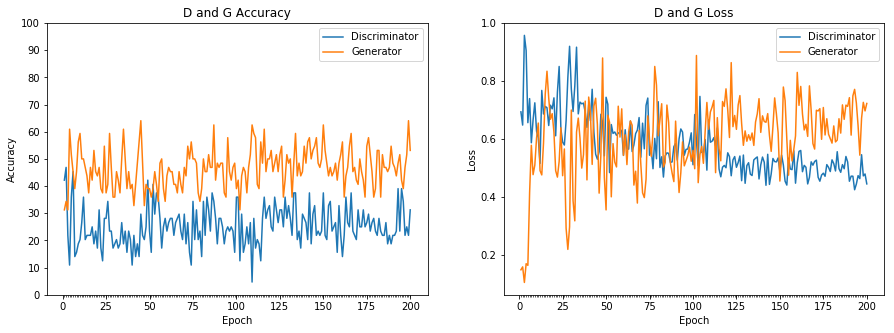

In [16]:
#    plot training graph
plot_training_history()


Overall accuracy: 95.100000% 


AveP: 94.051163% 

Classification report:
               precision    recall  f1-score   support

 Non-nunclei       0.93      0.98      0.95       500
      Nuclei       0.98      0.92      0.95       500

   micro avg       0.95      0.95      0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000




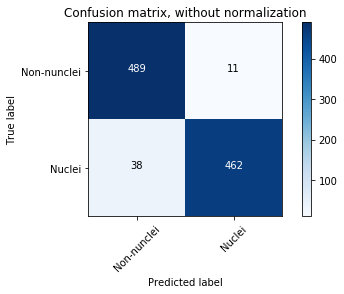

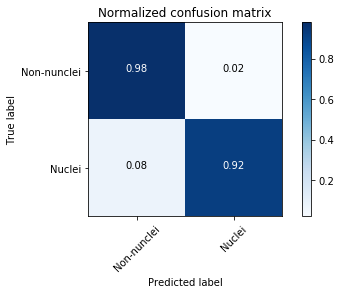

In [17]:
predict(X_test, y_test)